### Building a predictive model to identify the types of customers most likely to churn. 

In [293]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score , confusion_matrix , precision_score , recall_score

import warnings
warnings.filterwarnings('ignore')

#display all the columns
pd.set_option('display.max_columns', None)

## 1. Import data file

In [294]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---

## 2. EDA

In [295]:
df.shape

(7043, 21)

In [296]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [298]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [299]:
# as customerId feature has all unique values we can drop it from the dataset as it is not contributing towards the prediction model
print(f"Count of unique values of customerId features is {len(df['customerID'].unique())} which is same as the total number of recors.")

df = df.drop(columns=['customerID'])

Count of unique values of customerId features is 7043 which is same as the total number of recors.


In [300]:
cat_ft = [feature for feature in df.columns if df[feature].dtype=='O' and feature != 'Churn']
num_ft = [feature for feature in df.columns if df[feature].dtype!='O']
print(f"Observations:\n\t1. Categorical features count: {len(cat_ft)}\n\t2. Numerical features count: {len(num_ft)}")

Observations:
	1. Categorical features count: 15
	2. Numerical features count: 4


#### a. Missing Values

In [301]:
df.isnull().sum()
# TotalCharges feature have 11 missing values

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [302]:
nan_ft = 'TotalCharges'
print(np.round((df[nan_ft].isnull().mean())*100, 3), ' % missing values.')

0.156  % missing values.


#### b. Numerical Variables and its Distribution

In [303]:
# we have 4 numerical variables
print(f"{num_ft}\nCount: {len(num_ft)}")

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Count: 4


In [304]:
df['SeniorCitizen'].unique()

# senior citizen is actually a categorical variable with unique values as [0,1] so we should remove it from num_ft and put it into cat_ft list
num_ft.remove('SeniorCitizen')
cat_ft.append('SeniorCitizen')

Note: There is no tempora features in this dataset

In [305]:
df[num_ft].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [306]:
# filtering discrete features

# we will filter out those features that has unique features count less than 25 as discrete feature
dis_ft = [feature for feature in num_ft if len(df[feature].unique()) < 50]
len(dis_ft)

# from the count we can see that all the numerical feature have unique value count more than 50 so they all must be continuous variables

0

In [307]:
# filtering continuous features

# as seen above all the numerical features are continuous
cont_ft = num_ft

Frequency Distributions:


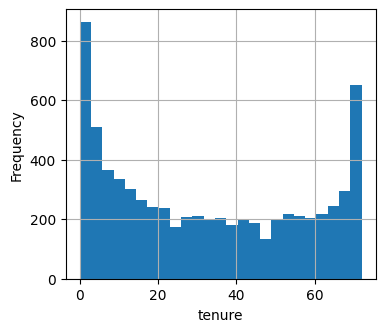

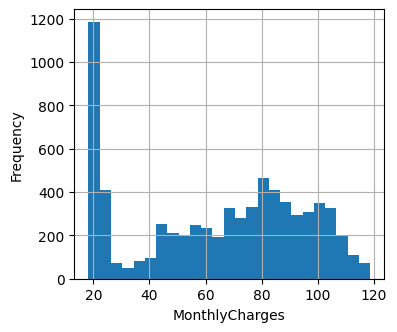

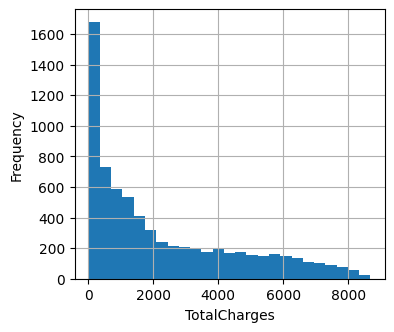

In [308]:
# From the above description of the numerical features we can see that the mean and the meadian of all the features are not having Guassian/Normal distribution

print("Frequency Distributions:")

for feature in cont_ft:
   plt.figure(figsize=(4, 3.5))
   df[feature].hist(bins=25)
   # plt.title(f'Frequency Distribution of {feature}')
   plt.xlabel(feature)
   plt.ylabel('Frequency')
   plt.show()

# we have to normalise them in Feature Engineering

#### c. Outliers

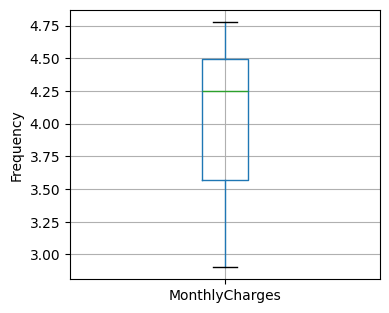

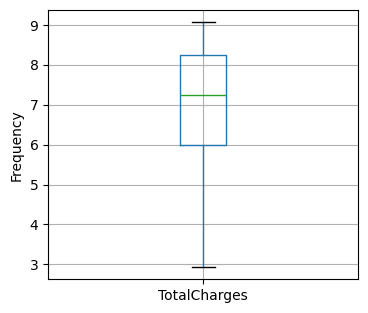

In [309]:
for feature in cont_ft:
   df_copy = df.copy()
   if 0 in df_copy[feature].unique():
      pass
   else:
      df_copy[feature] = np.log(df_copy[feature])
      plt.figure(figsize=(4, 3.5))
      df_copy.boxplot(column = feature)
      plt.ylabel('Frequency')
      plt.show()

In the above boxplots we can see that there are no outliers

#### d. Categorical Variable and their Cardinality

In [310]:
# we have already filtered out the Categorical features
print(f'{cat_ft}\nCount: {len(cat_ft)}')

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Count: 16


We have total 17 categorical features

In [311]:
# now let's find out the cardinality of each categorical features
for feature in cat_ft:
   print(f"{feature}: {len(df[feature].unique())}")

gender: 2
Partner: 2
Dependents: 2
PhoneService: 2
MultipleLines: 3
InternetService: 3
OnlineSecurity: 3
OnlineBackup: 3
DeviceProtection: 3
TechSupport: 3
StreamingTV: 3
StreamingMovies: 3
Contract: 3
PaperlessBilling: 2
PaymentMethod: 4
SeniorCitizen: 2


All the categorical variables have low cardinality which is idea. Maxium cardinality is 4.

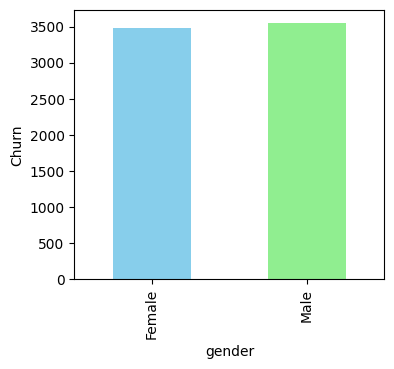

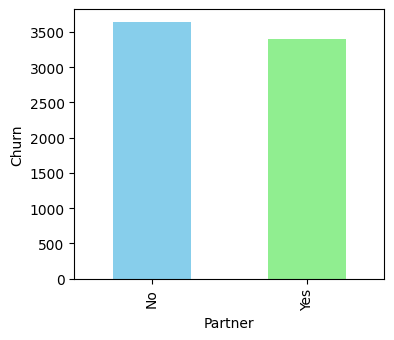

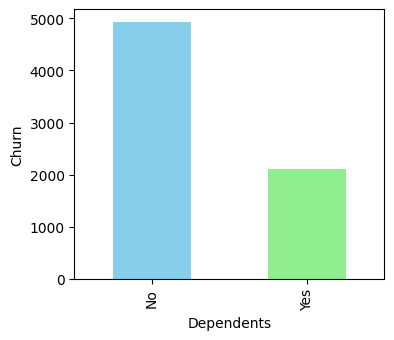

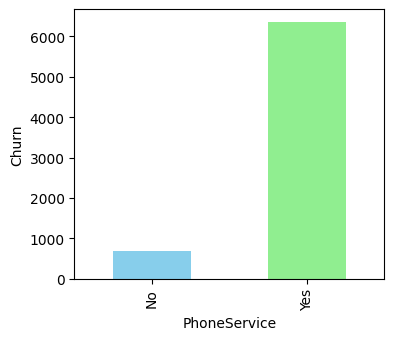

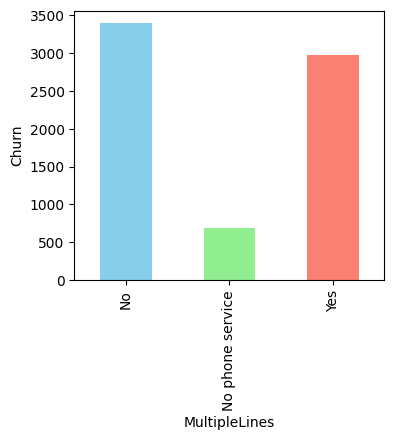

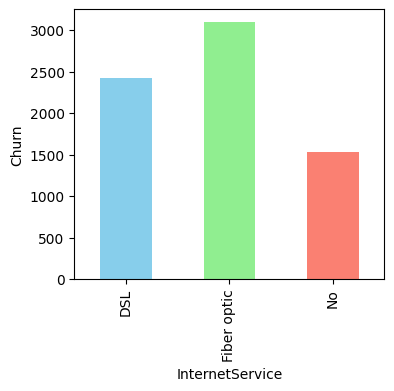

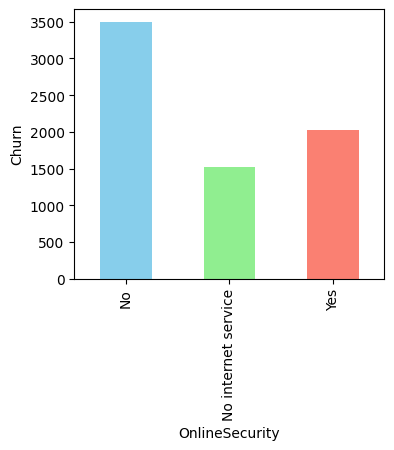

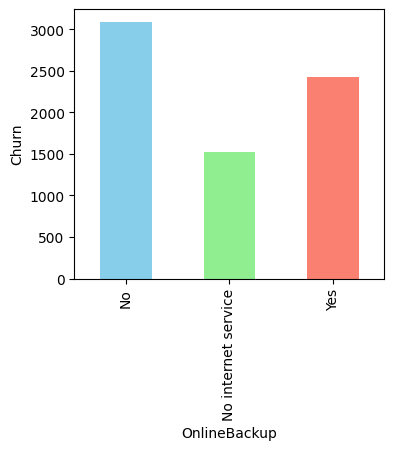

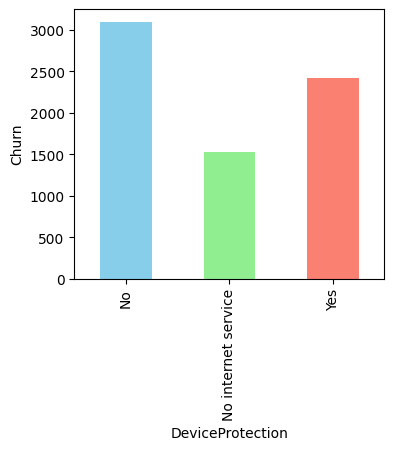

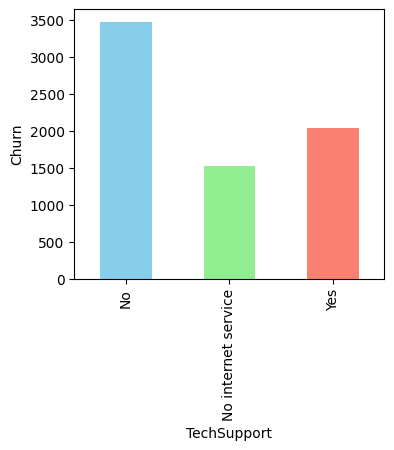

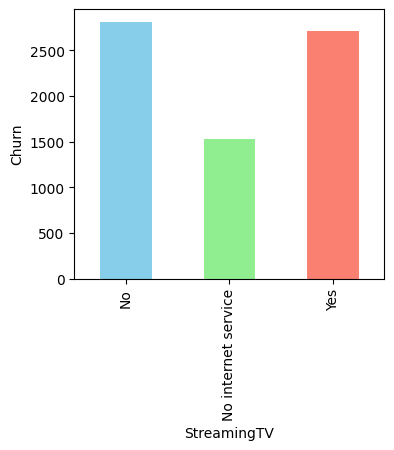

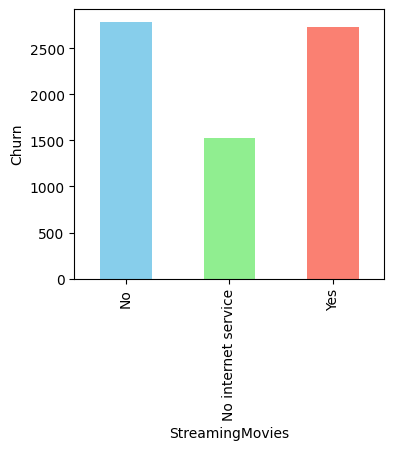

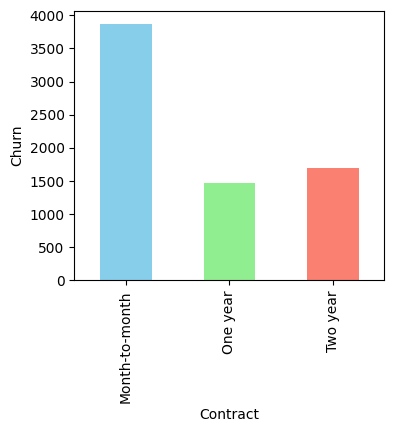

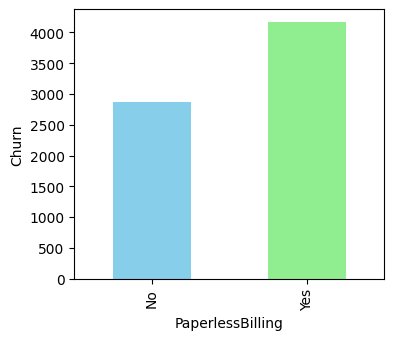

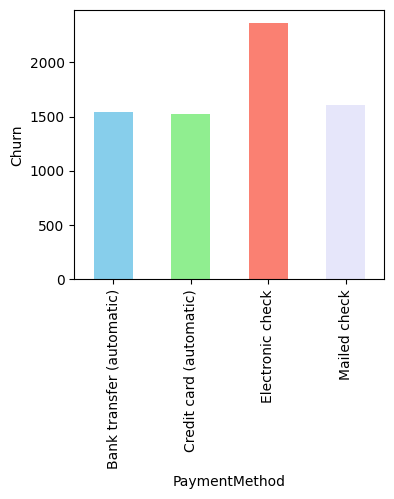

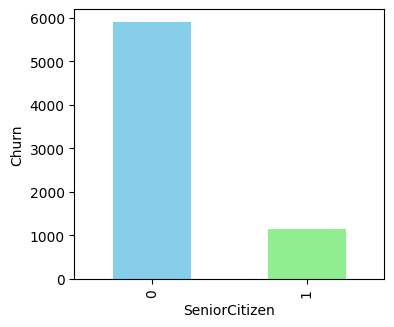

In [312]:
# relation of categorical variable with target variable
for feature in cat_ft:
   df_copy = df.copy()
   plt.figure(figsize=(4, 3.5))
   df_copy.groupby(feature)['Churn'].count().plot.bar(color=['skyblue', 'lightgreen', 'salmon', 'Lavender'])
   plt.ylabel('Churn')
   plt.xlabel(feature)
   plt.show

Using the bar plots we can clearly determine the counts of Churns based on each features

---

## 3. Feature Engineering

#### a. Spliting dataset into Test Train Split

In [313]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Churn'], test_size=0.2, random_state=0)

In [314]:
# #dropping the dependent feature form X_train and X_test datasets, also resetting the indexes
X_train = X_train.drop(['Churn'], axis=1)
X_train = X_train.reset_index(drop=True)

X_test = X_test.drop(['Churn'], axis=1)
X_test = X_test.reset_index(drop=True)

In [315]:
print(f"Training dataset Record Count: {X_train.shape[0]}")
print(f"Test dataset Record Count: {X_test.shape[0]}")

Training dataset Record Count: 5634
Test dataset Record Count: 1409


#### b. Handling missing values

less than 0.2% data is missing so that we can drop these<br>
or else we can simply impute them with median to be safe

##### i. Training Data:

In [316]:
median = X_train['TotalCharges'].median()
X_train['TotalCharges'] = X_train['TotalCharges'].fillna(median)
X_train.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

##### ii. Test Data:

In [317]:
median = X_test['TotalCharges'].median()
X_test['TotalCharges'] = X_test['TotalCharges'].fillna(median)
X_test.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

#### c. Normalization of Continuous features

##### i. Training Data:

            tenure  MonthlyCharges  TotalCharges
count  5634.000000     5634.000000   5634.000000
mean     32.377352        4.023287      6.939989
std      24.573875        0.594308      1.554203
min       0.000000        2.904165      2.936513
25%       9.000000        3.575501      6.003052
50%      29.000000        4.254193      7.242762
75%      56.000000        4.498559      8.243177
max      72.000000        4.777020      9.069330


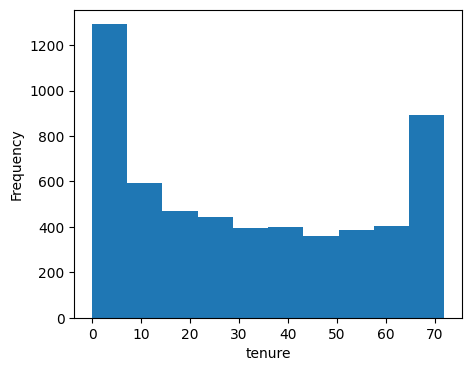

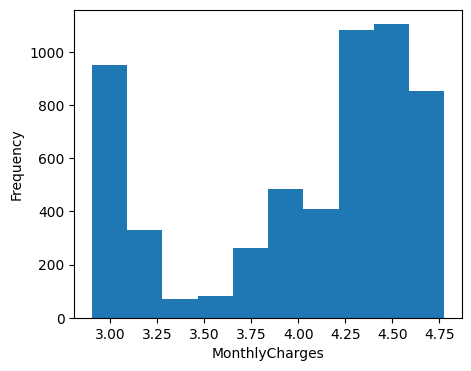

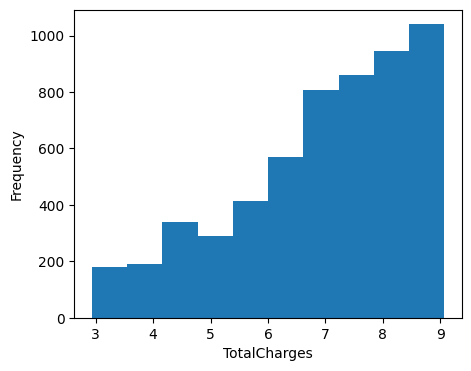

In [318]:
# normalizing the categorical feature with logarithmic transformation
for feature in cont_ft:
   if 0 in X_train[feature].unique():
      pass
   else:
      X_train[feature] = np.log(X_train[feature])
      

# checcking the values after normalization
print(X_train[cont_ft].describe())

for feature in cont_ft:
   plt.figure(figsize=(5, 4))
   plt.hist(X_train[feature], bins=10)
   plt.xlabel(feature)
   plt.ylabel('Frequency')
   plt.show()

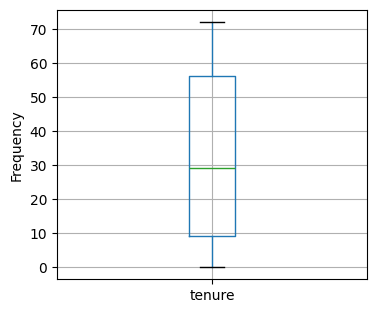

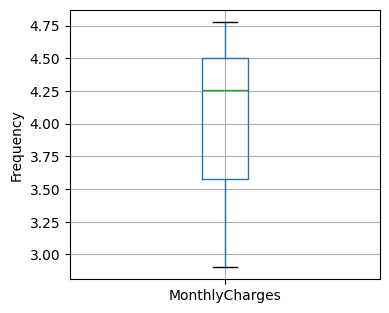

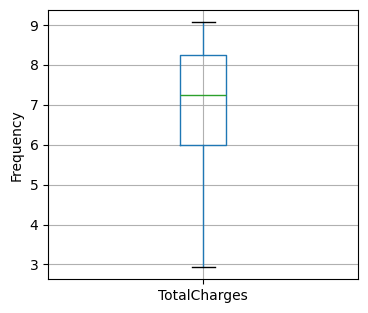

In [319]:
for feature in cont_ft:
   plt.figure(figsize=(4, 3.5))
   X_train.boxplot(column = feature)
   plt.ylabel('Frequency')
   plt.show()

##### ii. Test Data:

In [320]:
for feature in cont_ft:
   if 0 in X_test[feature].unique():
      pass
   else:
      X_test[feature] = np.log(X_test[feature])

#### d. Feature Scaling

In [321]:
# applying scaling on categorical features
# using Min-Max Scaler. We can also use One Hot Encoding

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

y_train = pd.get_dummies(y_train, drop_first=True)
y_test = pd.get_dummies(y_test, drop_first=True)

# sc = MinMaxScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test) 


In [322]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,72,4.443827,8.725085,False,True,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True
1,1,14,3.836221,6.511299,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
2,0,71,3.206803,7.501386,False,True,True,True,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False
3,0,33,4.302713,7.785326,True,True,True,True,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,True,False,True,False,False,True
4,0,47,4.592591,8.419294,False,True,False,True,False,True,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False


#### e. Saving the Train and test dataset after applying Feature Engineering

In [323]:
# X_train.to_csv('X_train.csv', index = False)
# X_test.to_csv('X_test.csv', index = False)

---

## 4. Feature Selection

In [324]:
# imported Lasso from linear model library and SelectFromModel from feature selection library available in sklearn

In [325]:
# applying feature selection
# specifying Lasso Regression Model and selecting a suitable alpha(equivalent of penality - bigger the value, less it will be selected) value

# then we will use SelectFromModel object which will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [326]:
# checking which features got rejected thier values will be False
print(feature_sel_model.get_support())

[ True  True  True  True False False  True False False  True  True  True
 False  True  True  True  True False False  True  True  True  True  True
  True  True  True False  True  True]


In [327]:
# filtering out the selected features
selected_ft = [X_train.columns[i] for i in range(len(X_train.columns)) if feature_sel_model.get_support()[i] == True]

# train data
X_train = X_train[selected_ft]

# test data
X_test = X_test[selected_ft]

#X_train.shape[1]

---

## 5. Model Training

This is a classification problem so we should use models like Logistic Regression, Decision Tree or Random Forest
<br> Random Forest will be the best choice as it is Ensemble of Decision Tree and thus it will give better result.

In [328]:
# # Decision Tree
# classifier = DecisionTreeClassifier()
# classifier.fit(X_train , y_train)

#Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train , y_train)

# # Random Forest
# classifier = RandomForestClassifier(n_estimators=100 , max_depth=3)
# classifier.fit(X_train, y_train)

LogisticRegression()

In [329]:
y_pred = classifier.predict(X_test)

## 6. Measuring Accuracy

In [330]:
acc = accuracy_score(y_pred , y_test)
cf  = confusion_matrix(y_pred , y_test)
precision  = precision_score(y_pred , y_test)
recall  = recall_score(y_pred , y_test)

print(f"Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}")

Accuracy: 0.7920511000709723
Precision: 0.49728260869565216
Recall: 0.6288659793814433


Logistic regression is giving better accuracy than Decision Tree and Random Forest.

<Axes: >

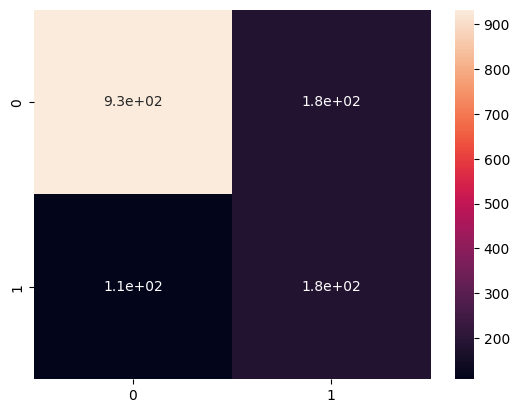

In [ ]:
sns.heatmap(cf, annot=True)